In [8]:
import os
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt

import fiona

In [6]:
#get band names
bandPath = './data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/'
bandNames = os.listdir(bandPath)
bandNames

['T18LUM_20200917T151709_B12.jp2',
 'T18LUM_20200917T151709_B11.jp2',
 'T18LUM_20200917T151709_B05.jp2',
 'T18LUM_20200917T151709_B02.jp2',
 'T18LUM_20200917T151709_TCI.jp2',
 'T18LUM_20200917T151709_B8A.jp2',
 'T18LUM_20200917T151709_B06.jp2',
 'T18LUM_20200917T151709_B07.jp2',
 'T18LUM_20200917T151709_B03.jp2',
 'T18LUM_20200917T151709_B10.jp2',
 'T18LUM_20200917T151709_B04.jp2',
 'T18LUM_20200917T151709_B09.jp2',
 'T18LUM_20200917T151709_B08.jp2',
 'T18LUM_20200917T151709_B01.jp2']

In [10]:
#import area of interest as Fiona geometry
aoiFile = fiona.open('./data/soilClassificationwithMachineLearningwithPythonScikitLearn/shp/AOI.shp')
aoiGeom = [aoiFile[0]['geometry']]

In [13]:
with open(os.path.join(bandPath, bandNames[0])) as f:
    print(f)

<_io.TextIOWrapper name='./data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/T18LUM_20200917T151709_B12.jp2' mode='r' encoding='UTF-8'>


In [15]:
with rasterio.open("./data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/T18LUM_20200917T151709_B01.jp2") as rasterBand:
    outImage, outTransform = mask(rasterBand, aoiGeom, crop=True)
    outMeta = rasterBand.meta
    outMeta.update({"driver": 'JP2OpenJPEG',
                    "height": outImage.shape[1],
                    "width": outImage.shape[2],
                    "transform": outTransform})
    outRaster = rasterio.open("./output/rst/test.jp2", "w", **outMeta) 
    outRaster.write(outImage)
    outRaster.close()

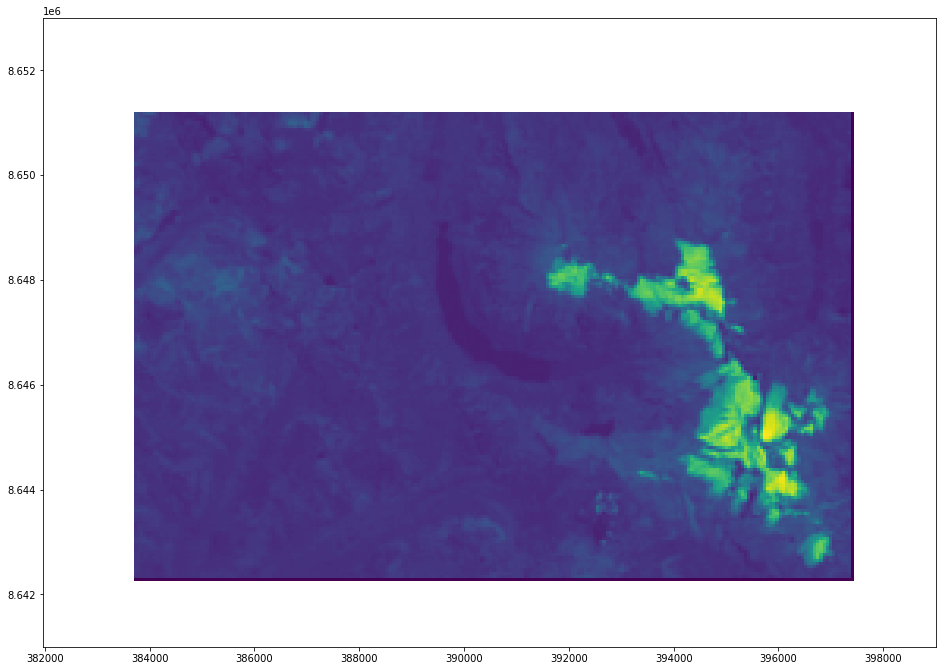

In [18]:
#plot original and clipped rasters
rasterBand = rasterio.open("./data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/T18LUM_20200917T151709_B01.jp2")
bandZero = rasterio.open("./output/rst/test.jp2",'r')
fig, ax = plt.subplots(figsize=(16,16))
#show(rasterBand, cmap='Blues', ax=ax)
show(bandZero, cmap='viridis', ax=ax)
ax.set_ylim(rasterBand.bounds.bottom,rasterBand.bounds.top)
ax.set_xlim(rasterBand.bounds.left,rasterBand.bounds.right)
plt.show()
bandZero.close()

In [84]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import time
import zarr
import numpy as np

# inspired by https://gist.github.com/lucaswells/fd2fd73c513872966c1a0257afee1887
def convert(raster_filepath, zarr_filepath, chunk_mbs=1):
    """
    Converts raster file to chunked and compressed zarr array.

    Parameters
    ----------
    raster_filepath : string
        Path and filename of input raster
    chunk_mbs : float, optional
        Desired size (MB) of chunks in zarr file
    """

    # Open the raster file
    raster = rasterio.open(raster_filepath)

    # Extract metadata we need for initializing the zarr array
    width = raster.width
    height = raster.height
    n_bands = raster.count
    dtype = raster.dtypes[0].lower()

    # Specify the number of bytes for common raster
    # datatypes so we can compute chunk shape
    dtype_bytes = {
        'byte'     : 1,
        'uint16'   : 2,
        'int16'    : 2,
        'uint32'   : 4,
        'int32'    : 4,
        'float32'  : 4,
        'float64'  : 8,
    }

    # Compute the chunk shape
    chunk_shape = (int((chunk_mbs * 1e6/dtype_bytes[dtype])**0.5),)*2

    # Create zarr store
    store = zarr.DirectoryStore(zarr_filepath)

    for k in raster.indexes:
        print(k)
        # Create zarr array for each band required
        zarray = zarr.create(
            shape=(height, width),
            chunks=chunk_shape,
            dtype=dtype,
            store=store,
            overwrite=True,
            path=k #TODO: replace k with the name of the band
        )

        # Let's add the metadata to the zarr file
        zarray.attrs['width'] = width
        zarray.attrs['height'] = height
        zarray.attrs['count'] = n_bands
        zarray.attrs['dtype'] = dtype
        zarray.attrs['bounds'] = raster.bounds
        zarray.attrs['transform'] = raster.transform
        zarray.attrs['crs'] = raster.crs.to_string()
        zarray.attrs['_ARRAY_DIMENSIONS'] = ['x', 'y'] #TODO: find a better way to do that
        #TODO: create coordinates for the zarr

        # Now we'll read and write the data according to the chuck size to prevent memory saturation
        for j in range(0, width+chunk_shape[1], chunk_shape[1]):
            print(f'column {j} of {width}')
            j = width if j > width else j
            for i in range(0, height+chunk_shape[0], chunk_shape[0]):
                i = height if i > height else i
                data = raster.read(k, window=Window(j, i, chunk_shape[1], chunk_shape[0]))
                zarray[i:i+chunk_shape[0], j:j+chunk_shape[1]] = data
    
    # Close the raster dataset; no need to close the zarr file
    raster.close()

    # Consolidate the metadata into a single .zmetadata file
    zarr.consolidate_metadata(store)

In [87]:
JP2_FILE = "./data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/T18LUM_20200917T151709_B01.jp2"
ZARR_FILE = "./output/zarr/test"
convert(JP2_FILE, ZARR_FILE)

1
column 0 of 284
column 707 of 284


In [88]:
import xarray as xr

xr.open_zarr(ZARR_FILE)

<xarray.Dataset>
Dimensions:  (x: 200, y: 284)
Dimensions without coordinates: x, y
Data variables:
    1        (x, y) float32 dask.array<chunksize=(200, 284), meta=np.ndarray>

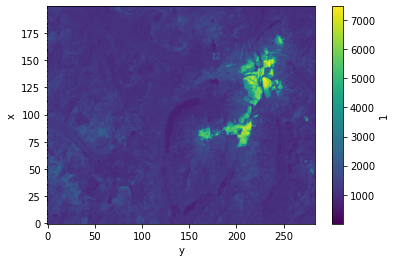

In [89]:
xr.open_zarr(ZARR_FILE).get("1").plot()